# 1. Setup

In [1]:
from mobilkit.umni import *

In [2]:
from bs4 import BeautifulSoup
import requests
from zipfile import ZipFile

# 2. AAA data
**Access Across America (AAA)** from [**Accessibility Observatory**](https://ao.umn.edu/) at the University of Minnesota

* **[Available datasets](https://ao.umn.edu/data/datasets)**
* **[Methodology report for transit access](https://ao.umn.edu/research/america/transit/2019/documents/AccessAcrossAmerica-Transit2019-Methodology.pdf)**
* **[Transit data documentation](https://conservancy.umn.edu/bitstream/handle/11299/218072/2019DataDoc_all_LEHD.pdf?sequence=51&isAllowed=y)**

## 2.1. Download for US
Do it by scraping file list from the main UMN AAA page.

### 2.1.1. For bike, drive & transit
- Download all available CSV files in the US using the URI handle for the webpage of each dataset (combination of mode and year).
- Here, the data of the year **2021** is used.
- Then, concatenate all modal tables into one file.

In [3]:
mode_handles = D(BIKE=256167, TRANSIT=256251, DRIVE=257163)
scale_labels = D(COUNTY='county', TRACT='census_tract', BG='block_group')

In [4]:
def get_aaa_data(mode_handles=mode_handles, scale_labels=scale_labels,
                 year=2021, overwrite=False):
    """Download AAA job accessibility data from the UMN server 
    for all the modes (except walking since that is problematic)
    for each state for three scales.

    Args:
        mode_handles (dict[str, int]): In the defaults, 
            the handles of year 2021 are used.
        scales (dict[str, str]): Labels of spatial scales keyed 
            by labels used in the AAA dataset and valued by the
            desired scale names.
    Returns:
        (Pdf): Output accessibility data table in long format 
            where `value` denotes the weighted average of job 
            counts for given travel time threshold.
    """
    outpath = Path(f'../data/aaa/us_{year}.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    root = 'https://conservancy.umn.edu'
    tempfile = Path('temp.zip')
    scales = {v: k for k, v in scale_labels.items()}
    df = []
    for mode, handle in mode_handles.items():
        url = f'{root}/handle/11299/{handle}'
        soup = BeautifulSoup(requests.get(url).text, 'html.parser')
        uris = [x.get('href', '') for x in soup.find_all('a')]
        uris = [x for x in uris if x.startswith('/bitstream/handle')]
        urls = {root + x for x in uris if '.zip' in x}
        for url in tqdm(urls, desc=mode):
            resp = requests.get(url)
            with open(tempfile, 'wb') as f:
                f.write(resp.content)
            with ZipFile(tempfile, 'r') as zipfile:
                for f in zipfile.namelist():
                    if (f.endswith('.csv') and not f.startswith('__MACOSX') 
                        and any([True for x in scales if x in f])):
                        with zipfile.open(f, 'r') as csv:
                            df.append(pd.read_csv(csv).assign(mode=mode))
    df = pd.concat(df).reset_index(drop=True)
    df = df.rename(columns=D(summary_level='scale', threshold='tt_thresh', 
                             weighted_average='value'))
    df = df.dropna(subset=['geoid'])
    df['geoid'] = df['geoid'].astype(int).astype(str).astype(CAT)
    df['scale'] = df['scale'].map(scales).astype(CAT)
    df['year'] = df['year'].astype(str).astype(CAT)
    df = df.astype(D(mode=CAT, tt_thresh=np.int16, value=np.float32))
    df = df[['mode', 'year', 'scale', 'geoid', 'tt_thresh', 'value']]
    df.to_parquet(U.mkfile(outpath))
    tempfile.unlink()
    return df

aaa = get_aaa_data(overwrite=0).disp() # t=1:26

8,487,310 rows x 6 cols; Memory: 132.5 MiB


,mode,year,scale,geoid,tt_thresh,value
,<category>,<category>,<category>,<category>,<int16>,<float32>
0,BIKE,2021,COUNTY,32001,300,185.529419


### 2.1.2. For walking
It works differently (and much worse) since walking does not have accessibility as such.

In [6]:
def get_walk_data(overwrite=False):
    outpath = Path('../data/aaa/us_walk_2014.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    root = 'https://conservancy.umn.edu/bitstream/handle/11299/'
    url = root + '173991/ALL_REGIONS_CSV_wa_2014_0700-0700.zip?sequence=111&isAllowed=y'
    resp = requests.get(url)
    tempfile = Path('temp.zip')
    with open(tempfile, 'wb') as f:
        f.write(resp.content)
    res = []
    with ZipFile(tempfile, 'r') as zipf:
        files = [f for f in zipf.namelist() if f[:8] != '__MACOSX']
        for f in tqdm(files):
            with zipf.open(f, 'r') as csv:
                df = pd.read_csv(csv)
            df['geoid'] = df['geoid10'].astype(str).str.zfill(15).str[:12]
            df = df.groupby('geoid')['jobs_tot'].sum().reset_index()
            res.append(df.assign(cbsa_id=f.split('_')[0]))
    df = pd.concat(res).reset_index(drop=True)
    df = df.dropna(subset=['jobs_tot']).astype(D(jobs_tot=np.int32))
    df.to_parquet(U.mkfile(outpath))
    tempfile.unlink()
    return df

walk = get_walk_data(overwrite=0).disp() # t=0:04

114,261 rows x 3 cols; Memory: 14.7 MiB


,geoid,jobs_tot,cbsa_id
,<object>,<int32>,<object>
0,130131801031,37572,12060


# 3. Visualize

In [6]:
aaa.pipe(lambda df: df[df.geoid.str[:2] == '18']).groupby('scale', observed=True).geoid.nunique()

scale
BG        4811
COUNTY      92
TRACT     1508
Name: geoid, dtype: int64

In [7]:
zones = gpd.read_parquet('../data/zones/in_2010.parquet').to_crs(CRS_M).disp()

6,417 rows x 6 cols; Memory: 1.3 MiB; CRS: EPSG:3857


,geoid,scale,county,aland,awater,geometry
,<object>,<object>,<object>,<int64>,<int64>,<geometry>
0,18001,COUNTY,Adams,878078983,2430463,"POLYGON ((-9440153.306878 4987988.233537, -944..."


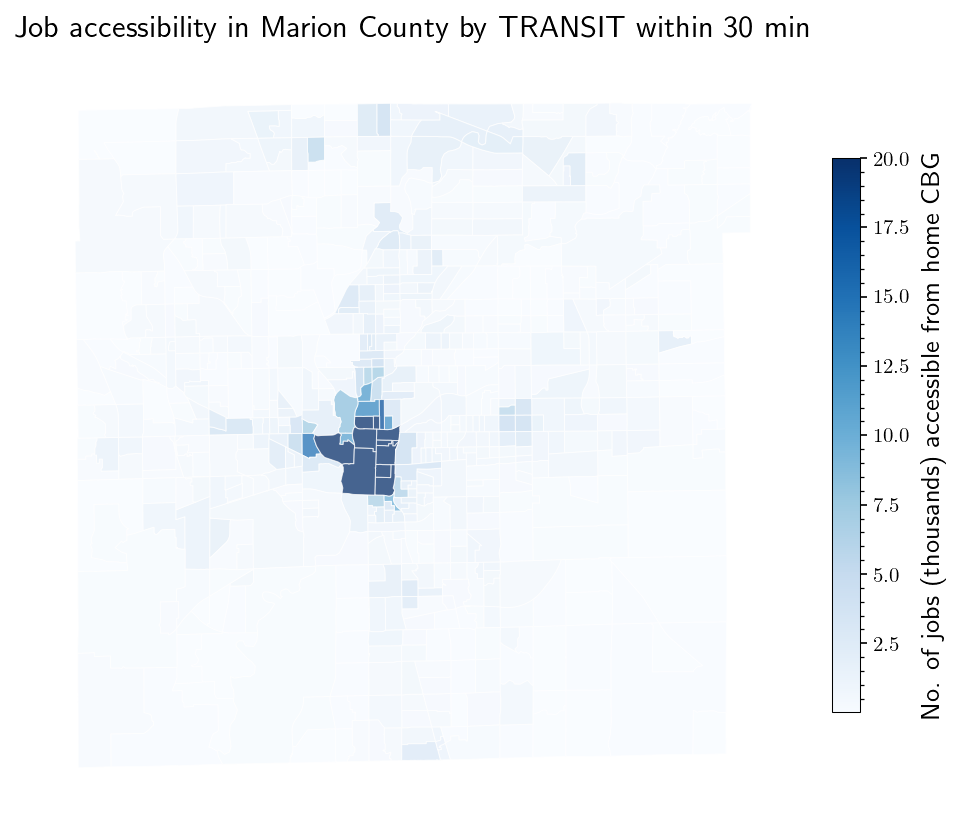

In [8]:
marion_fips = zones.query('scale=="COUNTY" & county=="Marion"').iloc[0].geoid
df = aaa.query('scale=="BG" & mode=="TRANSIT" & tt_thresh==900').pipe(
    lambda df: df[df.geoid.str[:5] == marion_fips])
df = zones.merge(df, on='geoid').assign(njobs=lambda df: df.value / 1000)
title = 'Job accessibility in Marion County by TRANSIT within 30 min'
ax = U.plot(size=(8, 8), axoff=1, title=title)
label = 'No. of jobs (thousands) accessible from home CBG'
df.plot(ax=ax, column='njobs', alpha=0.75, edgecolor='w', lw=0.5,
        cmap='Blues', vmax=20, legend=True, legend_kwds=D(
            shrink=0.6, label=label));
# ctx.add_basemap(ax=ax, crs=CRS_M);